# 1. Lecture CSV

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, recall_score, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
data_train = pd.read_csv("../datas/conversion_data_train_EDA.csv")
data_train.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# 2. Random Forest sur Train

On sépare les données en 2 : 1 set d'entrainement (80% des données), 1 set de test (20% des données)

In [3]:
target = "converted"

x = data_train.drop(target, axis = 1) 
y = data_train[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

Préprocessing :
- Standardisation / Mise à l'échelle des données
- Les variables catégorielles sont encodées en variables numériques entre 0 et 1

In [4]:
numerical_columns = x_train.select_dtypes(include=["float", "int"]).columns
categorical_columns = x_train.select_dtypes(include="object").columns

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ("encoder", OneHotEncoder(drop="first"))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_columns),
        ("cat", categorical_transformer, categorical_columns)
    ])

x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

### Modèle Random Forest Classifier

#### Entrainement du modèle et prédiction

In [5]:
rfc = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [200], # Nombre d'arbres à tester
    "max_depth": [10, 15], # Profondeur max des arbres
    "min_samples_leaf": [1, 5, 10], # nombre minimal d'échantillons dans le dernier niveau de l'arbre
    "class_weight": ["balanced", {0: 1, 1: 2}] # ajuste les poids associés à chaque classe
}

grid_search = GridSearchCV(rfc, param_grid, scoring="f1", cv=3, verbose=2)

grid_search.fit(x_train, y_train)

print("Best hyperparameters : ", grid_search.best_params_)
print("Best score : ", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   6.2s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   6.0s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   6.0s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=5, n_estimators=200; total time=   6.2s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=5, n_estimators=200; total time=   6.1s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=5, n_estimators=200; total time=   6.0s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=10, n_estimators=200; total time=   6.1s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=10, n_estimators=200; total time=   6.1s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=10, n_estimators=200; total time=   6.1s
[CV] END 

In [6]:
y_train_pred = grid_search.best_estimator_.predict(x_train)
y_test_pred = grid_search.best_estimator_.predict(x_test)

In [7]:
print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))
print()
print("recall_score on training set : ", recall_score(y_train, y_train_pred))
print("recall_score on test set : ", recall_score(y_test, y_test_pred))

f1-score on training set :  0.7763618540820614
f1-score on test set :  0.7668161434977578

recall_score on training set :  0.7555192150449714
recall_score on test set :  0.7455040871934605


#### Résumé des performances

In [8]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    219512
           1       0.80      0.76      0.78      7338

    accuracy                           0.99    226850
   macro avg       0.90      0.87      0.88    226850
weighted avg       0.99      0.99      0.99    226850



#### Matrices de confusion

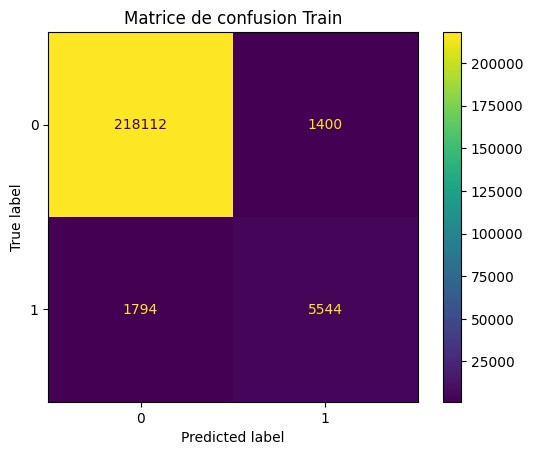

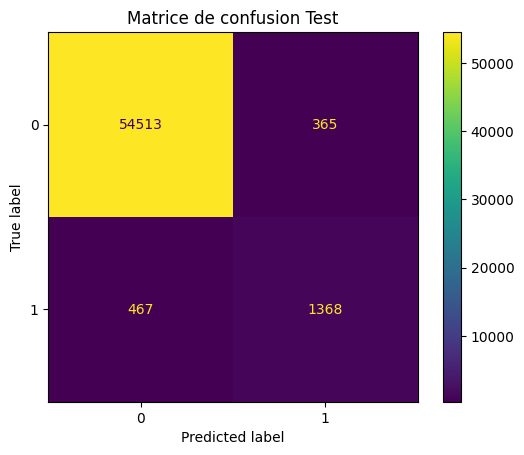

In [9]:
_, ax = plt.subplots()
ax.set(title="Matrice de confusion Train")
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, x_train, y_train, ax=ax)
plt.show()

_, ax = plt.subplots()
ax.set(title="Matrice de confusion Test")
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, x_test, y_test, ax=ax)
plt.show()

#### Courbes ROC

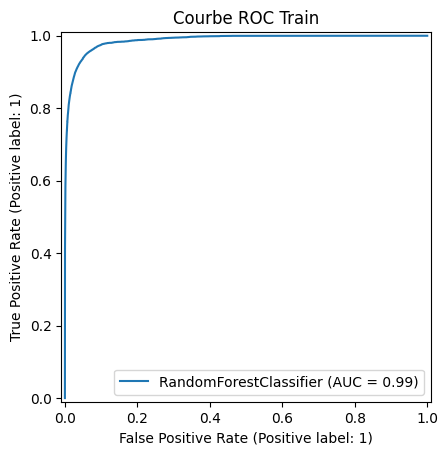

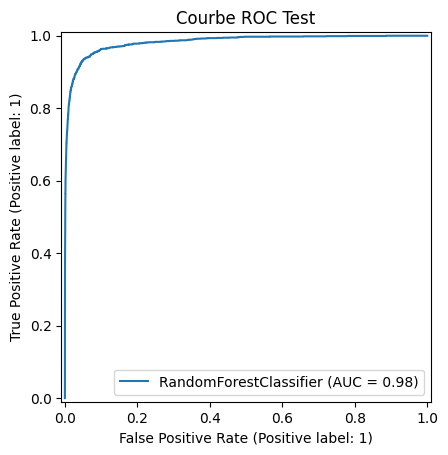

In [10]:
_, ax = plt.subplots()
ax.set(title="Courbe ROC Train")
RocCurveDisplay.from_estimator(grid_search.best_estimator_, x_train, y_train, ax=ax)
plt.show()

_, ax = plt.subplots()
ax.set(title="Courbe ROC Test")
RocCurveDisplay.from_estimator(grid_search.best_estimator_, x_test, y_test, ax=ax)
plt.show()

#### Conclusion

Le modèle Random Forest indique une légère amélioration par rapport à la régression logistique, notamment dans la capacité à identifier la classe minoritaire. 

Cependant il se peut qu'il y ait un léger surapprentissage d'après l'écart entre les scores d’entraînement et de test.

---

## Analyse des coefficients

In [11]:
column_names = []

for name, step, features_list in preprocessor.transformers_:
    if step == "drop" or step == "passthrough":
        continue

    if name == "num":
        features = features_list  # colonnes numériques : noms d'origine
    else:
        # Si step est une Pipeline, accéder au OneHotEncoder à l'intérieur
        if hasattr(step, "named_steps") and "encoder" in step.named_steps:
            encoder = step.named_steps["encoder"]
            features = encoder.get_feature_names_out(features_list)
        else:
            features = step.get_feature_names_out(features_list)

    column_names.extend(features)
     
# Create a pandas DataFrame
feature_importance = pd.DataFrame(
    index=column_names,
    data=grid_search.best_estimator_.feature_importances_,
    columns=["feature_importances"],
)
feature_importance = feature_importance.sort_values(by="feature_importances")

# Plot coefficients
fig = px.bar(feature_importance, orientation="h")
fig.update_layout(
    showlegend=False, margin={"l": 120}  # to avoid cropping of column names
)
fig.show()

D'après l'analyse des coefficients, la colonne `total_pages_visited` est très importante à la prédiction.

Je vais ajouter plusieurs colonnes au dataframe dans lesquelles je vais démultiplier cette colonne.

Puis je relance le modèle.

In [12]:
data_train["total_pages_visited_2"] = data_train["total_pages_visited"] * data_train["total_pages_visited"]
data_train["total_pages_visited_3"] = data_train["total_pages_visited"] * data_train["total_pages_visited"] * data_train["total_pages_visited"]
data_train["total_pages_visited_4"] = data_train["total_pages_visited"] * data_train["total_pages_visited"] * data_train["total_pages_visited"] * data_train["total_pages_visited"]
data_train["total_pages_visited_inverse"] = 1 / data_train["total_pages_visited"]
data_train["total_pages_visited_inverse_2"] = 1 / (data_train["total_pages_visited"] * data_train["total_pages_visited"])

target = "converted"

x = data_train.drop(target, axis = 1) 
y = data_train[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

grid_search.best_estimator_.fit(x_train, y_train)

y_train_pred = grid_search.best_estimator_.predict(x_train)
y_test_pred = grid_search.best_estimator_.predict(x_test)

print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))
print()
print("recall_score on training set : ", recall_score(y_train, y_train_pred))
print("recall_score on test set : ", recall_score(y_test, y_test_pred))

f1-score on training set :  0.7763618540820614
f1-score on test set :  0.7668161434977578

recall_score on training set :  0.7555192150449714
recall_score on test set :  0.7455040871934605


Je ne constate pas d'amélioration.

---

# 3. Prédictions sur Test

In [13]:
data_test = pd.read_csv("../datas/conversion_data_test_EDA.csv")

x_test = data_test
x_test = preprocessor.transform(x_test)

y_test = pd.read_csv("../datas/conversion_data_test_labels_EDA.csv")
y_pred = grid_search.best_estimator_.predict(x_test)

print("f1-score on set without labels : ", f1_score(y_test, y_pred))
print()
print("recall_score on set without labels : ", recall_score(y_test, y_pred))

f1-score on set without labels :  0.755578093306288

recall_score on set without labels :  0.7325467059980334


---

Sauvegarde des résultats dans un dataframe

In [14]:
scores_df = pd.DataFrame(columns = ["model", "f1", "recall"])

new_rows = [{"model": "rfc", "f1": f1_score(y_test, y_pred), "recall": recall_score(y_test, y_pred)}]

scores_df = pd.concat([scores_df, pd.DataFrame(new_rows)], ignore_index=True)
scores_df.to_csv("../datas/scores.csv", mode="a", header=False, index=False)

/tmp/ipykernel_25339/3509145647.py:5: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

